# CIFAR10 Neural Network

## 1. Libraries

To begin with let's load those libraries we need

In [20]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt
import numpy as np
import time
import datetime
from keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

## 2. Neural network architecture


In [22]:
model = ks.Sequential()

model.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', input_shape=(32,32,3), kernel_initializer = 'he_uniform', kernel_regularizer = l2(0.001)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_uniform', kernel_regularizer = l2(0.001)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_uniform', kernel_regularizer = l2(0.001)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_uniform', kernel_regularizer = l2(0.001)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(ks.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_uniform', kernel_regularizer = l2(0.001)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_uniform', kernel_regularizer = l2(0.001)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(ks.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_uniform', kernel_regularizer = l2(0.001)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(128, activation='relu', kernel_initializer = 'he_uniform', kernel_regularizer = l2(0.001)))
model.add(ks.layers.BatchNormalization())
model.add(Dropout(0.3))
model.add(ks.layers.Dense(10, activation='softmax'))


To review a model, we only need to call the **.summary()** method of the model

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

## 3. Optimizer, error function


In [24]:
from tensorflow.keras.optimizers import Adam
new_adam = Adam(learning_rate=0.0001, ema_momentum=0.8)
model.compile(optimizer=new_adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 4. Early Stopping

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
callback = EarlyStopping(monitor='val_loss', patience=10)

## 5. Prepare the data

We load the CIFAR10 data from the datasets directly from the Keras libraries. These are already set up in train and test.

**Important detail:**
> The neural network requires the inputs to be real numbers, and we will do this by forcing the division of the values inside the 28x28 matrices (which have values from 0 to 255) by 255.0 (one real).

In [27]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0

In [28]:
print("Etiquetas de train:", y_train)


# Convert data into one-dimensional arrays (vectors) is a good improvement in the dataset.
y_train = y_train.ravel()
y_test = y_test.ravel()


print("Etiquetas de train (en vector):", y_train)


Etiquetas de train: [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
Etiquetas de train (en vector): [6 9 9 ... 9 1 1]


We obtain an array with all the labels of CIFAR10

In [29]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Let's paint a sample of the images from the CIFAR10 dataset, and see if it looks anything like what we expect.
First, we see what data types I have, then we map those arrays into a grayscale using PlotLy's **.get_cmap()** method with the first nine numbers of the dataset.

Train: X=(50000, 32, 32, 3), y=(50000,)
Test: X=(10000, 32, 32, 3), y=(10000,)


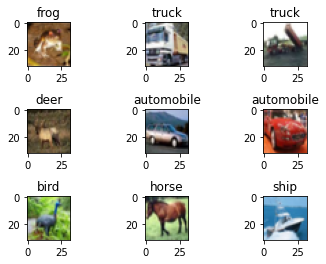

In [30]:
# Let's paint a sample of the MNIST dataset images.

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train[i]])

plt.subplots_adjust(hspace = 1)
plt.show()

As we will want to be doing validation while training (very practical).

In [31]:
x_val_scaled = x_train_scaled[-10000:]
y_val = y_train[-10000:]

x_train_scaled = x_train_scaled[:-10000]
y_train = y_train[:-10000]


When we add convolutions, we need to "pre-process the data", because **convolution expects a 4-field matrix** (more like "images"), in the case of MNIST. CIFAR10 already has the right shape, so we don't have to do anything, but as we always say: it is better that you check its size.

That's why, when you exit the Convolution, you have to do a Flatten, because FullDense layers expect arrays, not matrices!!!

Then we print it to see that everything is correct.

In [32]:
# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train_scaled.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test_scaled.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val_scaled.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000,)
Test: X=(10000, 32, 32, 3), y=(10000,)
Validation: X=(10000, 32, 32, 3), y=(10000,)


## 6. Train

In [33]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

In [34]:
it_train = datagen.flow(x_train_scaled, y_train, batch_size=64)

In [35]:
t = time.perf_counter()

In [36]:
steps = int(x_train_scaled.shape[0] / 64)
history = model.fit(it_train, steps_per_epoch=steps, epochs=100, callbacks=[callback], validation_data=(x_val_scaled, y_val))

Epoch 1/100
625/625 [==============================] - 33s 43ms/step - loss: 3.7834 - accuracy: 0.2378 - val_loss: 3.4017 - val_accuracy: 0.2927
Epoch 2/100
625/625 [==============================] - 29s 46ms/step - loss: 3.2983 - accuracy: 0.3300 - val_loss: 3.0580 - val_accuracy: 0.4041
Epoch 3/100
625/625 [==============================] - 26s 42ms/step - loss: 3.1000 - accuracy: 0.3800 - val_loss: 2.9675 - val_accuracy: 0.4234
Epoch 4/100
625/625 [==============================] - 27s 42ms/step - loss: 2.9507 - accuracy: 0.4227 - val_loss: 2.9189 - val_accuracy: 0.4362
Epoch 5/100
625/625 [==============================] - 27s 43ms/step - loss: 2.8297 - accuracy: 0.4545 - val_loss: 2.8300 - val_accuracy: 0.4601
Epoch 6/100
625/625 [==============================] - 26s 42ms/step - loss: 2.7138 - accuracy: 0.4820 - val_loss: 2.7793 - val_accuracy: 0.4746
Epoch 7/100
625/625 [==============================] - 27s 43ms/step - loss: 2.6113 - accuracy: 0.5071 - val_loss: 2.7207 - val_ac

In [37]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:55:15.557620


## 7. Evaluate the results

Let's obtain a graph of how the error and accuracy evolve at each epoch in the training and validation data.

In [38]:
_, acc = model.evaluate(x_test_scaled, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 86.610


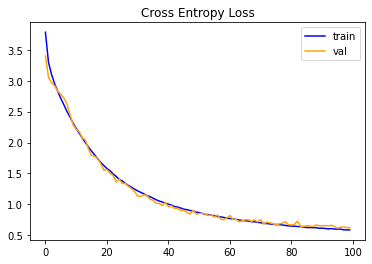

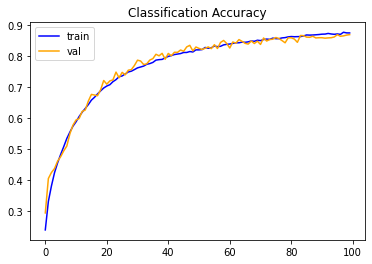

In [39]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

Let's see what kind of predictions I am getting on the test set (let's paint the images and their classifications).

In [40]:
predictions = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [41]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

We draw the first images, with the predictions and their real values.

We color the correct predictions in blue and the failures in red. But first I have printed the labels so that we have a reference to the graph.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


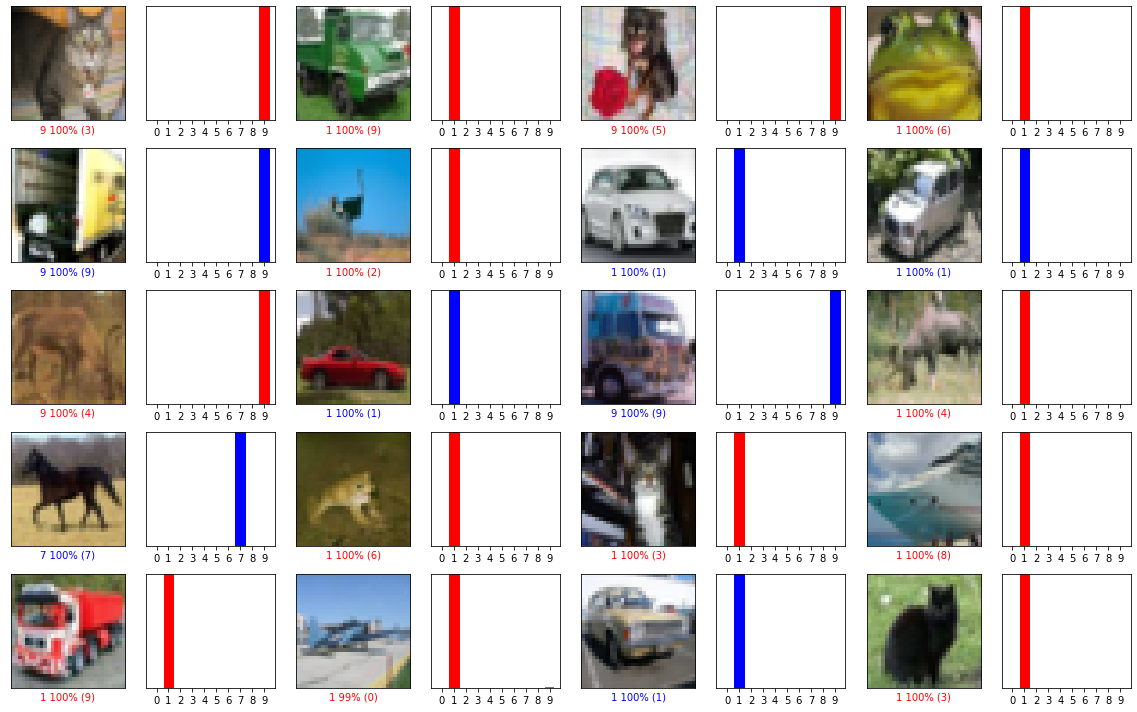

In [42]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()